# Analysis: Client DEAD

Included below is is an example of our inferential analysis using linear regression, applied to a random sample of 100,000 transactions from Iowa. We aim to produce a modeling process that can provide insights into the factors influencing alcohol purchasing behavior.

In this specific instance, given a dataset of transactions, we want to predict liters purchased per transaction in the year 2022. We will then evaluate the effect size of each variable to analyze alcohol purchasing factors.

## Setup

We use the following packages:
- `pandas` as a tool for tabular and relational data engineering
- `numpy` as a tool for vectorized mathematical operations
- `datetime` as a package for datetime data management and manipulation
- `holidays` as a package for identifying holidays for analytical purposes
- `sodapy` as a tool to query random samples from the Iowa Liquor sales data.
- `matplotlib` as a visualization tool
- `squarify` as a visualization tool

In [1]:
!pip install sodapy
!pip install squarify

In [2]:
import pandas as pd
import numpy as np
import holidays
import datetime
from sodapy import Socrata
import matplotlib.pyplot as plt
import squarify

Here, we suppress unneccesary warnings for cleaner output.

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Data Collection

### Liquor Sales

Using `sodapy`, we can directly query the [Iowa Liquor Sales](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) database for a random sample of data.

We also mutated a column for the day of the week and the month for each transaction, within the SQL code.

In [4]:
# date_extract_dow() - 0 = Sunday, 6 = Saturday
client = Socrata("data.iowa.gov", None)
q = """
  select Date, date_extract_m(Date) as Month, date_extract_dow(Date) as DayOfWeek, name as StoreName, Zipcode, City, County, category_name, sale_liters, sale_dollars, state_bottle_retail
  where date_extract_y(date) >= 2022
  LIMIT 100000
"""
results = client.get("m3tr-qhgy", query=q)
df_liquor = pd.DataFrame.from_records(results)

In [5]:
df_liquor.head()

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,state_bottle_retail
0,2022-06-17T00:00:00.000,6,5,WAL-MART 3394 / ATLANTIC,50022,ATLANTIC,CASS,AMERICAN VODKAS,10.50,132.78,22.13
1,2022-06-16T00:00:00.000,6,4,HY-VEE / WAVERLY,50677,WAVERLY,BREMER,CANADIAN WHISKIES,12.00,99.00,8.25
2,2022-02-01T00:00:00.000,2,2,EAST SIDE LIQUOR & GROCERY / MARSHALLTOWN,50158,MARSHALLTOWN,MARSHALL,AMERICAN FLAVORED VODKA,9.00,81.00,6.75
3,2022-06-10T00:00:00.000,6,5,CENTRAL CITY 2,50314,DES MOINES,POLK,AMERICAN VODKAS,12.00,144.00,12.00
4,2022-06-10T00:00:00.000,6,5,YESWAY STORE # 10018/ WEBSTER CITY,50595,WEBSTER CITY,HAMILTON,SPICED RUM,9.00,180.00,7.50


### Colleges

We want include variables regarding Iowa colleges in our inferential analysis on what kind of factors drive alcohol purchasing behavior. We source this information from [Wikipedia](https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa). This includes information on the institution, its city, and its enrollment numbers in 2012.

In [6]:
url = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa"
df_colleges = pd.read_html(url)[0]

In [7]:
df_colleges.head()

,Institution,Location(s)[note 2],Control[note 3],Type[note 4],Enrollment[7] (spring 2012),Founded,Accreditation[7]
0,University of Iowa,Iowa City,Public,Research university,"31,498[8]",1847[9],"HLC, ACPE, ABA, ADA, APTA, APA, ASHA, CPE, CAH..."
1,Iowa State University,Ames,Public,Research university,34732,1858[10],"HLC, AAMFT, ADA, APA, AVMA, NASM"
2,University of Northern Iowa,Cedar Falls,Public,Master's university,13168,1876[11],"HLC, ASHA, NASM"
3,Clinton Community College,Clinton,Public,Associate's college,1700,1946[12],HLC
4,Des Moines Area Community College,Ankeny,Public,Associate's college,25425,1966[13],"HLC, ABFSE, ADA, NLNAC"


## Feature Engineering

### Defining Functions

We define custom functions here to apply in a vectorized manner to existing columns, in order to create engineer new features.

- `near_holi`: Determines if a date is within two weeks of a US holiday. Returns 1 if it is, and 0 if not.

- `alc_type_cat`: Simplifies the alcohol types into fewer categories. Takes in an alcohol category, and returns a more general one.

- `classify_college_size`: Categorizes college enrollment numbers into large (10000+), midsize (3000 to 10000), or small (less than 3000).

In [8]:
def near_holi(date, us_holidays):
  return int(bool(us_holidays[date - datetime.timedelta(weeks=2):date]))

In [9]:
def alc_type_cat(alc):
    alc_categories = {
        "VODKA": ["VODKA"],
        "WHISKY": ["WHISKY", "WHISKIES"],
        "RUM": ["RUM"],
        "GIN": ["GIN"],
        "TEQUILA": ["TEQUILA"],
        "BRANDY": ["BRANDIES", "BRANY"],
        "SCHNAPPS": ["SCHNAPPS"],
        "SPIRITS": ["SPIRITS"],
    }

    for category, keywords in alc_categories.items():
        for keyword in keywords:
          try:
            if keyword in alc:
                return category
          except:
            return "OTHER"
    return "OTHER"

In [10]:
def classify_college_size(enrollment):
    if enrollment > 10000:
        return "Large"
    elif enrollment > 3000:
        return "Midsize"
    else:
        return "Small"

### Feature Creation/Manipulation

Firstly, we clean the college data in preparation for merging it with our IOWA alcohol sales data.

We then clean the liquor sales data with the following steps:
- Turning columns into numeric data when necessary
- Filtering out returns, ie. negative sales
- Removing missing data

In [11]:
df_colleges.rename(columns={"Location(s)[note 2]": "City"}, inplace=True)
df_colleges.rename(columns={"Enrollment[7] (spring 2012)": "Enrollment"}, inplace=True)
df_colleges = df_colleges[["Institution", "City", "Enrollment"]]
df_colleges["City"] = df_colleges["City"].str.upper()

In [12]:
df_liquor["sale_liters"] =df_liquor["sale_liters"].astype(float)
df_liquor["sale_dollars"] = df_liquor["sale_dollars"].astype(float)

In [13]:
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor.dropna(subset=['City', 'Zipcode', 'County'], inplace=True)

Finally, we develop and clean the following features:
- NearHoliday: Whether a transaction occurred within two weeks leading up to a holiday
- CostPerLiter: The dependent feature, calculated by dividing total sales by total liters
- Category: Simplified alcohol categorizations
- CategoryNum: Simplified alcohol categorizations, in numeric form (see code for the mapping).
- Size: Categorized college enrollment sizes of all colleges in each City; small (less than 3000), midsize (3000 to 10000), or large (greater than 10000)
- Sale Amount: Sales by liter categorized into small (less than the median) or large (greater than the median) sales

We then join the liquor data with college data.

In [14]:
df_liquor["Date"] = df_liquor["Date"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f"))
df_liquor["NearHoliday"] = df_liquor["Date"].apply(near_holi, args=(holidays.country_holidays('US', years=range(2012, 2024)),))
df_liquor["CostPerLiter"] = df_liquor["sale_dollars"] / df_liquor["sale_liters"]
df_liquor["Category"] = df_liquor["category_name"].map(alc_type_cat)
df_liquor["CategoryNum"] = df_liquor["Category"].map(
    {
        "VODKA": 1,
        "WHISKY": 2,
        "RUM": 3,
        "GIN": 4,
        "TEQUILA": 5,
        "BRANDY": 6,
        "SCHNAPPS": 7,
        "SPIRITS": 8,
        "OTHER": 9
      })
df_colleges["Student Pop"] = df_colleges["Enrollment"].str.replace(r"\[.*\]", "", regex=True)
df_colleges["Student Pop"] = df_colleges["Student Pop"].str.replace(",", "").astype(int)
student_pop = pd.DataFrame(df_colleges.groupby("City")["Student Pop"].sum())
college_count = pd.DataFrame(df_colleges.groupby("City")["Institution"].count())
student_pop = student_pop.merge(college_count, how="left", on="City")
student_pop["Size"] = student_pop["Student Pop"].apply(classify_college_size)
student_pop
# !!!Size is from 2012 data!!!
df_liquor = df_liquor.merge(student_pop, how="left", on="City")

We further clean and finalize the combined college and liquor dataset:

In [15]:
df_liquor["Institution"].fillna(0, inplace=True)
df_liquor["Student Pop"].fillna(0, inplace=True)
df_liquor["Size"].fillna("None", inplace=True)

In [16]:
df_liquor['City'] = df_liquor['City'].astype("category")
df_liquor['County'] = df_liquor['County'].astype("category")
df_liquor['category_name'] = df_liquor['category_name'].astype("category")
df_liquor['StoreName'] = df_liquor['StoreName'].astype("category")
df_liquor['Size'] = df_liquor['Size'].astype("category")
df_liquor['Zipcode'] = df_liquor['Zipcode'].astype("category")

In [17]:
med = df_liquor["sale_liters"].astype(float).describe()["50%"]
df_liquor["Sale Amount"] = df_liquor["sale_liters"].map(lambda y: "Large" if y >= med else "Small")

### Save Data to CSV

In [18]:
df_liquor.to_csv("client_b", index=False)
df_liquor.head()

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,state_bottle_retail,NearHoliday,CostPerLiter,Category,CategoryNum,Student Pop,Institution,Size,Sale Amount
0,2022-06-17,6,5,WAL-MART 3394 / ATLANTIC,50022,ATLANTIC,CASS,AMERICAN VODKAS,10.5,132.78,22.13,0,12.645714,VODKA,1,0.0,0.0,None,Large
1,2022-06-16,6,4,HY-VEE / WAVERLY,50677,WAVERLY,BREMER,CANADIAN WHISKIES,12.0,99.00,8.25,0,8.250000,WHISKY,2,1805.0,1.0,Small,Large
2,2022-02-01,2,2,EAST SIDE LIQUOR & GROCERY / MARSHALLTOWN,50158,MARSHALLTOWN,MARSHALL,AMERICAN FLAVORED VODKA,9.0,81.00,6.75,0,9.000000,VODKA,1,2026.0,1.0,Small,Large
3,2022-06-10,6,5,CENTRAL CITY 2,50314,DES MOINES,POLK,AMERICAN VODKAS,12.0,144.00,12.00,1,12.000000,VODKA,1,11454.0,4.0,Large,Large
4,2022-06-10,6,5,YESWAY STORE # 10018/ WEBSTER CITY,50595,WEBSTER CITY,HAMILTON,SPICED RUM,9.0,180.00,7.50,1,20.000000,RUM,3,0.0,0.0,None,Large


## Model Fitting

To have consisten results, we saved a random run of the above code and used this to create our models.

### Data

In [19]:
df_liquor = pd.read_csv("https://raw.githubusercontent.com/mshsu/data403-project1/main/client_b", low_memory=False)

We first standardize all numeric variables, in order to better compare the effect sizes.

In [20]:
df_liquor["CostPerLiter_std"] = (df_liquor["CostPerLiter"] - df_liquor["CostPerLiter"].mean()) / df_liquor["CostPerLiter"].std()
df_liquor["CategoryNum_std"] = (df_liquor["CategoryNum"] - df_liquor["CategoryNum"].mean()) / df_liquor["CategoryNum"].std()
df_liquor["StudentPop_std"] = (df_liquor["Student Pop"] - df_liquor["Student Pop"].mean()) / df_liquor["Student Pop"].std()
df_liquor["Institution_std"] = (df_liquor["Institution"] - df_liquor["Institution"].mean()) / df_liquor["Institution"].std()

## Functions

Here, we define custom functions created to perform ridge regression model creation, selection, and analysis (descriptions inline).

In [21]:
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def ridge(X, Y, l, intercept):
  """
  Inputs:
    X: numpy array of predictors
    y: numpy array of value to predict
    l: lambda
    intercept: boolean flag; true if intercept in model false if not

  Compute beta estimate(s) for Ridge regression
  """
  if intercept:
    ones_col = np.ones((X.shape[0], 1))
    X = np.hstack((ones_col, X))

  return np.linalg.inv(X.T @ X + l * np.identity(X.shape[1])) @ (X.T @ Y)
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def try_many_lambdas(X, Y, l_lst, intercept):
  """
  Computes Ridge estimators for a list of lambda values where:
    loss = Sq Error
  """
  df_results = pd.DataFrame(data={"lambda": l_lst})
  results = df_results["lambda"].apply(lambda l: ridge(X, Y, l, intercept))

  return pd.DataFrame(results.tolist())
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice):
  """
  Compute chosen validation metric for a list of lambdas where:
    loss = Sq Error
  using test and training data

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df_train: df of training data
  df_test: df of testing data
  Y: String with name of response
  m_choice: an list of int(s) corresonding metric(s)
  """
  X_train = df_train.drop([Y], axis=1)
  X_test = df_test.drop([Y], axis=1)
  Y_train = df_train[Y]
  Y_test = df_test[Y]

  df_results = try_many_lambdas(X_train.to_numpy(), Y_train.to_numpy(), l_lst, intercept)

  if intercept:
    X_test.insert(0, "b0", 1)

  df_results["y_hat"] = df_results.apply(lambda row: X_test.to_numpy() @ row.to_numpy(), axis=1)
  df_results["lambda"] = l_lst

  n = len(Y_test)
  keep = ["lambda"]
  if 1 in m_choice:
    df_results["r_sqr"] = df_results.apply(lambda row: 1 - sum((Y_test - row["y_hat"]) ** 2) / sum((Y_test - Y_test.mean()) ** 2), axis=1)
    keep.append("r_sqr")

  if 2 in m_choice:
    df_results["MSE"] = df_results.apply(lambda row: 1 / n * sum((Y_test - row["y_hat"]) ** 2), axis=1)
    keep.append("MSE")

  if 3 in m_choice:
    df_results["MAE"] = df_results.apply(lambda row: sum(abs(Y_test - row["y_hat"])) / n, axis=1)
    keep.append("MAE")

  return df_results[keep]
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_cv(df, Y, l_lst, intercept, m_choice, n_split):
  """
  Compute avg chosen validation metric for a list of lambdas using v-fold cross-validation

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df: Pandas DataFrame of ONLY predictors and response
  Y: String with name of response
  intercept: boolean flag; true if intercept in model false if not
  m_choice: an list of int(s) corresonding metric(s)
  """
  df = df.sample(frac=1, random_state=43)
  fold_size = len(df) // n_split
  df["Fold"] = np.append(np.repeat(range(1, n_split+1), fold_size), np.repeat(n_split,len(df) % n_split))

  df_results = pd.DataFrame()
  for n in range(1, n_split+1):
    df_test = df[df["Fold"] == n].drop(["Fold"], axis=1)
    df_train = df[df["Fold"] != n].drop(["Fold"], axis=1)
    df_results = pd.concat([df_results, tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice)])

  return df_results.groupby("lambda").mean()
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def compare_B(B, X, Y):
  predictors = pd.DataFrame(X).columns.to_list()
  predictors.insert(0, "intercept")
  return pd.DataFrame({"B": ridge(X, Y, 10, True)}, index=predictors).sort_values("B", ascending=False)

### Models

Finally, we iterate through multiple linear regression models with various ridge penalties, in order to create a wide range of models from which to select a best model to "explain" sales per liter.

We validate each model through k-fold cross-validation.

#### Model 0

With Model 0, we use NearHoliday, CostPerLiter, CategoryNum, StudentPop and DayOfWeek.

The best $R^2$ appears around $\lambda=100$.

In [22]:
df_m0 = df_liquor[['sale_liters', 'NearHoliday','CostPerLiter_std', 'CategoryNum_std', 'StudentPop_std', 'DayOfWeek']]
df_m0 = pd.get_dummies(df_m0, columns=["DayOfWeek"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m0, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.006959,1440.954040,7.909039
2,0.006959,1440.954004,7.908985
3,0.006959,1440.953971,7.908932
4,0.006959,1440.953940,7.908879
5,0.006959,1440.953911,7.908827
10,0.006960,1440.953780,7.908570
100,0.006961,1440.952302,7.904119
1000,0.006945,1440.985853,7.864697


#### Model 1

With Model 1, we use NearHoliday, CostPerLiter, StudentPop and Category.

The best $R^2$ appears around $\lambda=100$.

In [23]:
df_m1 = df_liquor[['sale_liters', 'NearHoliday','CostPerLiter_std', 'StudentPop_std', 'Category']]
df_m1 = pd.get_dummies(df_m1, columns=["Category"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m1, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.007322,1440.440366,7.894118
2,0.007322,1440.440343,7.894065
3,0.007322,1440.440320,7.894011
4,0.007322,1440.440298,7.893957
5,0.007322,1440.440276,7.893904
10,0.007322,1440.440167,7.893636
100,0.007324,1440.438900,7.888863
1000,0.007303,1440.474031,7.845945


#### Model 2

With Model 2, we use NearHoliday, CostPerLiter, Category and Institution.

The best $R^2$ appears around $\lambda=100$.

In [24]:
df_m2 = df_liquor[['sale_liters', 'NearHoliday','CostPerLiter_std', 'Category', 'Institution_std']]
df_m2 = pd.get_dummies(df_m2, columns=["Category"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m2, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.007700,1440.011053,7.898609
2,0.007700,1440.011031,7.898555
3,0.007700,1440.011010,7.898500
4,0.007700,1440.010989,7.898445
5,0.007700,1440.010968,7.898391
10,0.007700,1440.010866,7.898118
100,0.007701,1440.009767,7.893249
1000,0.007675,1440.049017,7.849157


#### Model 3

With Model 3, we use Month, Size, Category, NearHoliday, Instituion, DayOfWeek, and County.

The best $R^2$ appears around $\lambda=100$.

In [25]:
df_m3 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek", "County"]]
df_m3 = pd.get_dummies(df_m3, columns=["Month", "Category", "Institution", "DayOfWeek", "County", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m3, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.006436,1441.690045,8.182435
2,0.006440,1441.684839,8.181802
3,0.006443,1441.679774,8.181180
4,0.006447,1441.674843,8.180571
5,0.006451,1441.670039,8.179971
10,0.006468,1441.647738,8.177141
100,0.006595,1441.478604,8.145308
1000,0.006300,1441.898752,8.059024


#### Model 4

With Model 4, we use Month, Size, Category, NearHoliday, Institution, and DayOfWeek.

The best $R^2$ appears around $\lambda=1000$.

In [26]:
df_m4 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek"]]
df_m4 = pd.get_dummies(df_m4, columns=["Month", "Category", "Institution", "DayOfWeek", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m4, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.005076,1443.639799,8.096820
2,0.005076,1443.639587,8.096755
3,0.005077,1443.639384,8.096691
4,0.005077,1443.639190,8.096629
5,0.005077,1443.639001,8.096567
10,0.005078,1443.638111,8.096259
100,0.005086,1443.625993,8.090813
1000,0.005087,1443.624394,8.044913


#### Model 5

With Model 5, we use NearHoliday, CostPerLiter, StudentPop and Category.

The best $R^2$ appears around $\lambda=100$.

In [27]:
df_m5 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution"]]
df_m5 = pd.get_dummies(df_m5, columns=["Month", "Category", "Institution", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m5, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004163,1444.913729,8.052948
2,0.004163,1444.913607,8.052891
3,0.004163,1444.913488,8.052834
4,0.004163,1444.913371,8.052777
5,0.004164,1444.913255,8.052720
10,0.004164,1444.912704,8.052436
100,0.004169,1444.906036,8.047544
1000,0.004158,1444.925782,8.008171


#### Model 6

With Model 6, we use Month, Size, Category, and NearHoliday.

The best $R^2$ appears around $\lambda=100$.

In [28]:
df_m6 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday"]]
df_m6 = pd.get_dummies(df_m6, columns=["Month", "Category", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m6, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004054,1445.010479,8.049351
2,0.004054,1445.010406,8.049299
3,0.004054,1445.010334,8.049248
4,0.004054,1445.010265,8.049196
5,0.004054,1445.010197,8.049144
10,0.004055,1445.009884,8.048886
100,0.004058,1445.007170,8.044433
1000,0.004042,1445.042980,8.006787


#### Model 7

With Model 7, we use Month, Category, NearHoliday, and Institution

The best $R^2$ appears around $\lambda=100$.

In [29]:
df_m7 = df_liquor[["sale_liters", "Month", "Category", "NearHoliday", "Institution"]]
df_m7 = pd.get_dummies(df_m7, columns=["Month", "Category", "Institution"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m7, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004078,1445.035760,8.037064
2,0.004078,1445.035650,8.037004
3,0.004078,1445.035542,8.036944
4,0.004078,1445.035436,8.036884
5,0.004078,1445.035333,8.036824
10,0.004078,1445.034845,8.036525
100,0.004083,1445.029551,8.031391
1000,0.004063,1445.058111,7.988296


We plan to use the validation metrics generated from these models to choose an appropriate one from which to analyze effect size and make inferences on alcohol purchasing behavior trends.

# Final Model

We decided to select Model 2 as our final model due to it achieving the largest $\small{R^2}$ value as well as having better easy to interpret predictors.

In [30]:
df_final_model = df_liquor[['sale_liters', 'NearHoliday', 'CostPerLiter_std', 'Institution_std', 'Category']]
df_final_model = pd.get_dummies(df_final_model, columns=["Category"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000, 1500]
tune_lambda_cv(df_final_model, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.007700,1440.011053,7.898609
2,0.007700,1440.011031,7.898555
3,0.007700,1440.011010,7.898500
4,0.007700,1440.010989,7.898445
5,0.007700,1440.010968,7.898391
10,0.007700,1440.010866,7.898118
100,0.007701,1440.009767,7.893249
1000,0.007675,1440.049017,7.849157
1500,0.007645,1440.092310,7.827959


To determine meaningful factors, we investigated the magnitude of the slope coefficients, which we are able to compare since we standardized our predictors prior to running the model.

In [31]:
X = df_final_model.drop(["sale_liters"], axis=1)
Y = df_final_model["sale_liters"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 100, True)
df_B = compare_B(B, X, Y)
df_B

,B
intercept,6.012856
Category_VODKA,3.563122
Category_RUM,2.925903
NearHoliday,2.114321
Category_SCHNAPPS,1.515519
Institution_std,1.049535
Category_WHISKY,0.655983
Category_OTHER,0.574633
Category_GIN,0.066007
Category_TEQUILA,0.007095


To better visualize the magnitudes of the coefficients, we created a tree map and labled the largest coefficients.

In [32]:
y_labels = {'Category_BRANDY': 'Brandy', 'Category_GIN': 'Gin',
            'Category_OTHER': 'Other Alcohol', 'Category_RUM': 'Rum',
            'Category_SCHNAPPS': 'Schapps', 'Category_SPIRITS': 'Spirits',
            'Category_TEQUILA': 'Tequila', 'Category_VODKA': 'Vodka',
            'Category_WHISKY': 'Whisky', 'CostPerLiter_std': 'Cost Per Liter',
            'Institution_std': 'Num Colleges in \nCity',
            'NearHoliday': 'Near Holiday', 'intercept': 'Intercept'}

df_B = df_B.drop('intercept',axis=0)
df_B = df_B.reset_index()
df_B['index'] = df_B['index'].map(y_labels)
df_B['abs B'] = abs(df_B['B'])

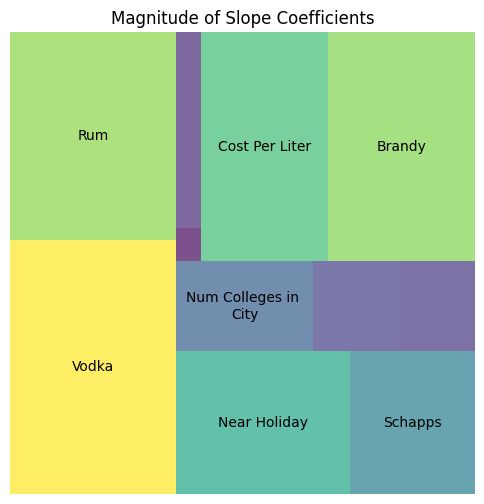

In [55]:
filtered_labels = [label if size >= 1 else '' for label, size in zip(df_B['index'], df_B['abs B'])]

norm = plt.Normalize(min(df_B['abs B']), max(df_B['abs B']))
colors = [plt.cm.viridis(norm(value)) for value in df_B['abs B']]
plt.figure(figsize=(6, 6))
squarify.plot(sizes=df_B['abs B'], label=filtered_labels, color=colors, alpha=0.7)
plt.axis('off')
plt.title('Magnitude of Slope Coefficients')

plt.show()

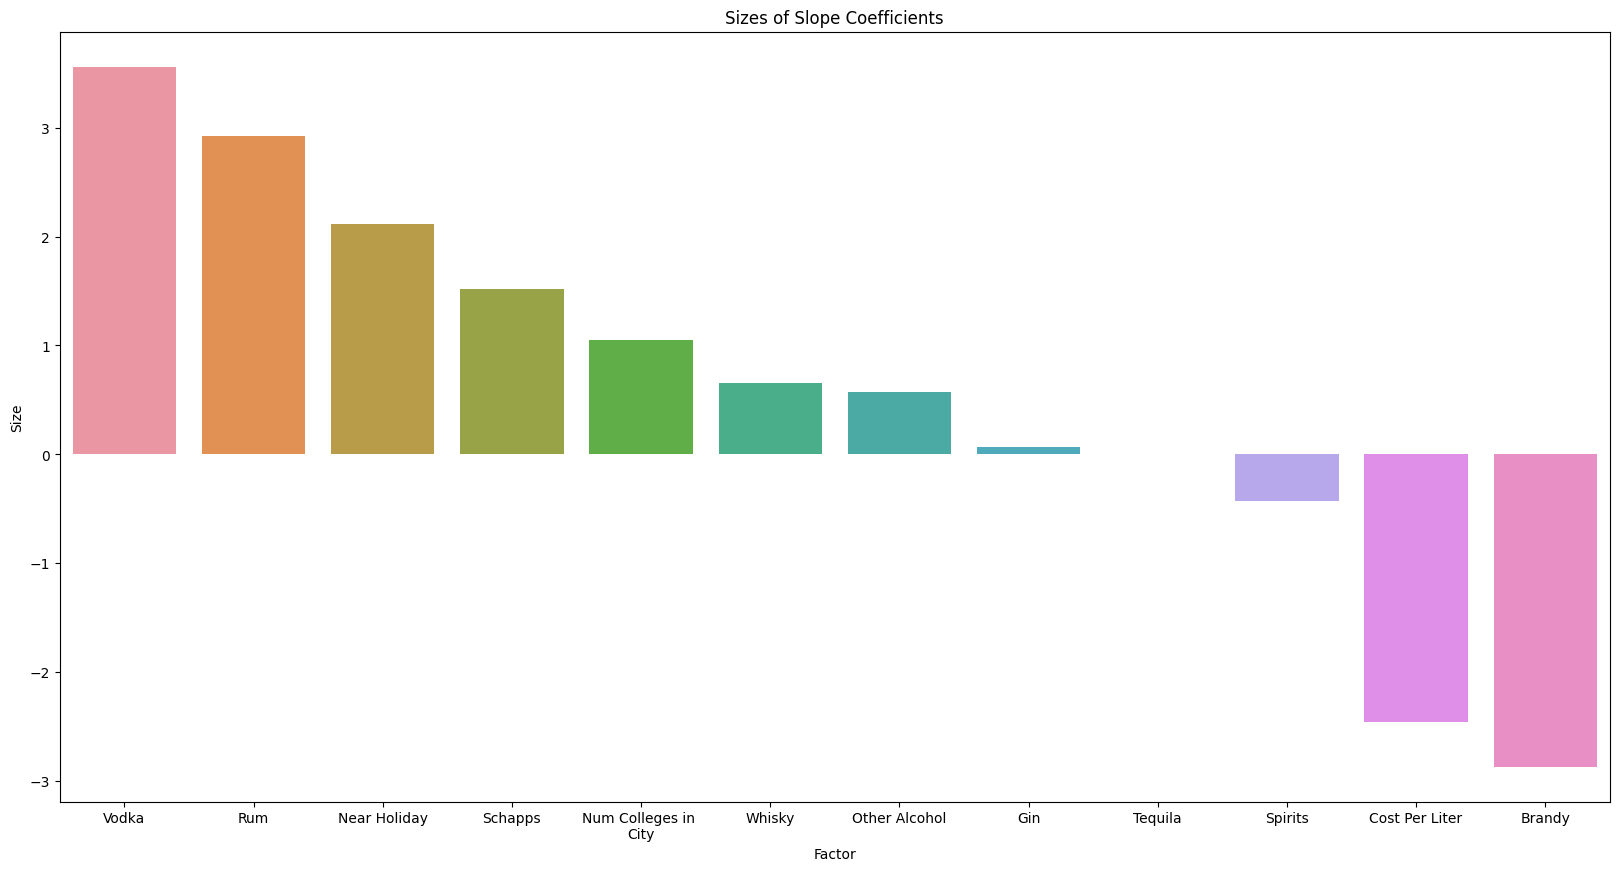

In [56]:
# ADDED FOR FINAL REPORT (POST PRESENTATION)
import seaborn as sns
plt.figure(figsize=(20, 10))
p = sns.barplot(x=df_B['index'], y=df_B['B'])
plt.title('Sizes of Slope Coefficients')
p.set_ylabel('Size')
p.set_xlabel('Factor')

plt.show()

## Sources

US Holidays: https://pypi.org/project/holidays/

In [34]:
us_holidays = holidays.country_holidays('US', years=2012)
for day in us_holidays.items():
    print(day)

(datetime.date(2012, 1, 16), 'Martin Luther King Jr. Day')
(datetime.date(2012, 2, 20), "Washington's Birthday")
(datetime.date(2012, 10, 8), 'Columbus Day')
(datetime.date(2012, 1, 1), "New Year's Day")
(datetime.date(2012, 1, 2), "New Year's Day (Observed)")
(datetime.date(2012, 5, 28), 'Memorial Day')
(datetime.date(2012, 7, 4), 'Independence Day')
(datetime.date(2012, 9, 3), 'Labor Day')
(datetime.date(2012, 11, 11), 'Veterans Day')
(datetime.date(2012, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2012, 11, 22), 'Thanksgiving')
(datetime.date(2012, 12, 25), 'Christmas Day')


Iowa Colleges: https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa